# Module 2: Load and interact with velocity fields

In this module you will learn how to load a dataset (velocity)
onto the grid we have previously defined and interact with it. <br>

let's include the previous module and make sure the grid is correctly defined
This can be done using the `@nbinclude` macro from the NBInclude package

In [2]:
# Pkg.add("NBInclude")
using NBInclude

# Let's include the previous notebook
@nbinclude("01_build_a_discrete_ocean.ipynb")

@show grid;

    Updating registry at `/srv/julia/pkg/registries/General.toml`
   Resolving package versions...
   Installed NBInclude ─ v2.3.0
    Updating `/srv/julia/pkg/environments/v1.7/Project.toml`
  [0db19996] + NBInclude v2.3.0
    Updating `/srv/julia/pkg/environments/v1.7/Manifest.toml`
  [0db19996] + NBInclude v2.3.0
Precompiling project...
  ✓ NBInclude
  1 dependency successfully precompiled in 2 seconds (231 already precompiled)
   Resolving package versions...
  No Changes to `/srv/julia/pkg/environments/v1.7/Project.toml`
  No Changes to `/srv/julia/pkg/environments/v1.7/Manifest.toml`


size(bathymetry) = (1440, 600)
typeof(bathymetry) = Matrix{Float64}
grid = 360×180×1 ImmersedBoundaryGrid{Float64, Periodic, Bounded, Bounded} on CPU with 3×3×3 halo:
├── immersed_boundary: GridFittedBoundary{Field{Center, Center, Center, Nothing, LatitudeLongitudeGrid{Float64, Periodic, Bounded, Bounded, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, Float64, Float64, Float64, Float64, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}, CPU}, Tuple{Colon, Colon, Colon}, OffsetArrays.OffsetArray{Bool, 3, Array{Bool, 3}}, Bool, FieldBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryCo

### Download velocity datasets

To download the (precomputed) velocity datasets we, once again, use the `Downloads` package.

The file containing the velocity datasets can be found online at https://github.com/simone-silvestri/coessing-data/raw/main/prescribed_mean_fields.jld2

In [5]:
onlinepath = "https://github.com/simone-silvestri/coessing-data/raw/main/"

file_path = download(onlinepath * "prescribed_mean_fields.jld2", "./prescribed_mean_fields.jld2")

file_velocities = jldopen(file_path)


JLDFile /home/jovyan/coessing2022-hub/julia-ocean-model/prescribed_mean_fields.jld2 (read-only)
 ├─🔢 um
 └─🔢 vm

This file is again a Dictionary containing two datasets:
- um
- vm 

Here `um` is the _zonal_ surface velocity (the surface velocity in the West-East direction) <br>
and `vm` is the _meridional_ surface velocity (the surface velocity in the South-North direction). <br>
 
these datasets contain the ***average*** of the velocities over a time span of 10 years. <br>
Let's assign these datasets to two variables and look at their structure

In [6]:
const Um = file_velocities["um"]
const Vm = file_velocities["vm"]

@show typeof(Um);
@show size(Um);
@show typeof(Vm)
@show size(Vm);

typeof(Um) = Array{Float64, 3}
size(Um) = (1440, 600, 1)
typeof(Vm) = Array{Float64, 3}
size(Vm) = (1440, 601, 1)


Note that they are both ***3D*** arrays! Oceananigans always works with three dimensional data for simplicity, <br>
a two dimensional dataset (as in this case) is a 3D array with ***one*** point in the unused direction

let's plot the zonal velocity with `CairoMakie`. 

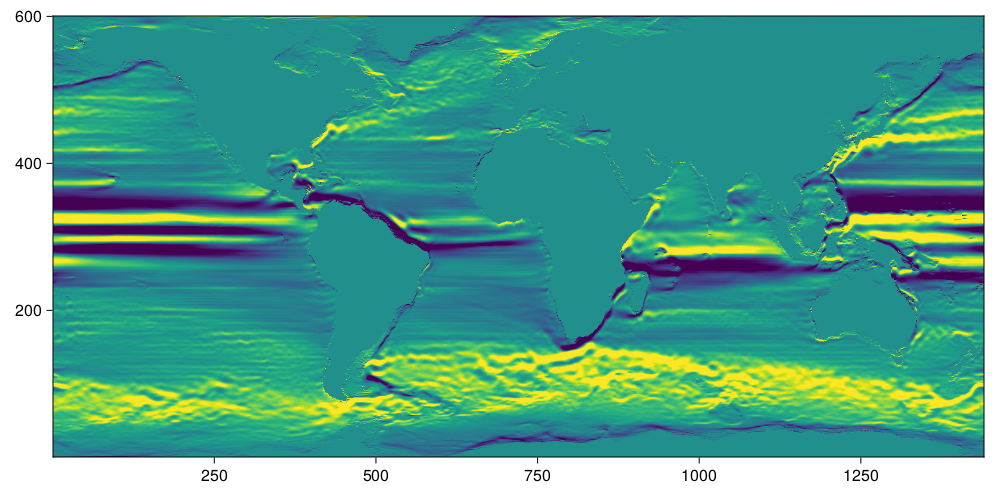

In [7]:
# Mean zonal velocity
fig = Figure(resolution = (1000, 500))
ax  = Axis(fig[1, 1])
heatmap!(ax, Um[:, :, 1], colorrange = (-0.2, 0.2))
current_figure()

At the moment the velocity has zero values where the continents are supposed to be. <br>
To better visualize the datasets, let's create a "continent mask" to overlay to our velocity. <br>
We want to have a mask that has all the elements for which `bathymetry > 0` (over sea level) equal to `NaN`s (these will be our continents) <br> and all elements for which `bathymetry < 0` (the ocean) equal to `0`. 

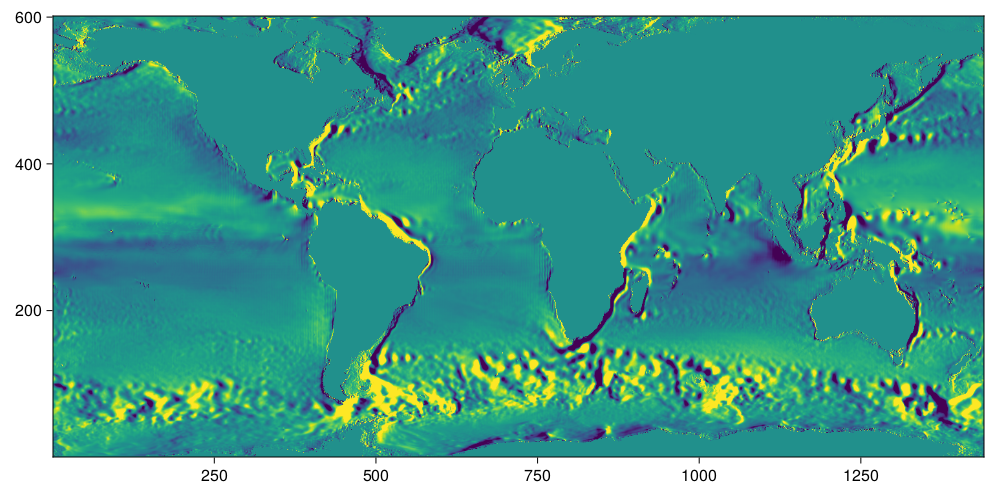

In [8]:
# Mean meridional velocity
v = Vm[:, :, 1]

fig = Figure(resolution = (1000, 500))
ax  = Axis(fig[1, 1])
heatmap!(ax, v, colorrange = (-0.1, 0.1))
current_figure()

### Second building block: Fields!

Oceananigans represents variables connected to a particular grid with a `Field` type. <br> 
Fields are essentially containers which include the grid, the data allocated on the grid (the previously seen 3D arrays), <br>
as well as the eventual boundary conditions.

We can define empty fields (i.e., empty containers) for our velocities and fill them with the velocity data we loaded

In [15]:
include("utils/useful_functions.jl")
U = XFaceField(grid)
V = YFaceField(grid)

set_velocity_from_array!(U, Um)
set_velocity_from_array!(V, Vm)

360×181×1 Field{Center, Face, Center} on ImmersedBoundaryGrid on CPU
├── grid: 360×180×1 ImmersedBoundaryGrid{Float64, Periodic, Bounded, Bounded} on CPU with 3×3×3 halo
├── boundary conditions: FieldBoundaryConditions
│   └── west: Periodic, east: Periodic, south: Nothing, north: Nothing, bottom: ZeroFlux, top: ZeroFlux, immersed: ZeroFlux
└── data: 366×187×7 OffsetArray(::Array{Float64, 3}, -2:363, -2:184, -2:4) with eltype Float64 with indices -2:363×-2:184×-2:4
    └── max=0.795497, min=-1.12417, mean=0.00555245

### Combining fields

Fields are handy because they can be combined through expressions. <br>
as an example, let's calculate the mean kinetic energy at the surface defined as

$$K = 0.5 * (U^2 + V^2)$$

In [16]:
K = Field(0.5 * (U^2 + V^2))
compute!(K)

360×180×1 Field{Face, Center, Center} on ImmersedBoundaryGrid on CPU
├── grid: 360×180×1 ImmersedBoundaryGrid{Float64, Periodic, Bounded, Bounded} on CPU with 3×3×3 halo
├── boundary conditions: FieldBoundaryConditions
│   └── west: Periodic, east: Periodic, south: ZeroFlux, north: ZeroFlux, bottom: ZeroFlux, top: ZeroFlux, immersed: ZeroFlux
├── operand: BinaryOperation at (Face, Center, Center)
├── status: time=0.0
└── data: 366×186×7 OffsetArray(::Array{Float64, 3}, -2:363, -2:183, -2:4) with eltype Float64 with indices -2:363×-2:183×-2:4
    └── max=0.441604, min=0.0, mean=0.00697706

Now let's see how kinetic energy of the surface looks like. <br>
We can plot is trough `CairoMakie` as we have done before, but we have to extract data from the field to plot it! <br>

To access the data associated with an Oceananigans field we can use the function `interior`

typeof(k) = SubArray{Float64, 3, Array{Float64, 3}, Tuple{UnitRange{Int64}, UnitRange{Int64}, UnitRange{Int64}}, false}


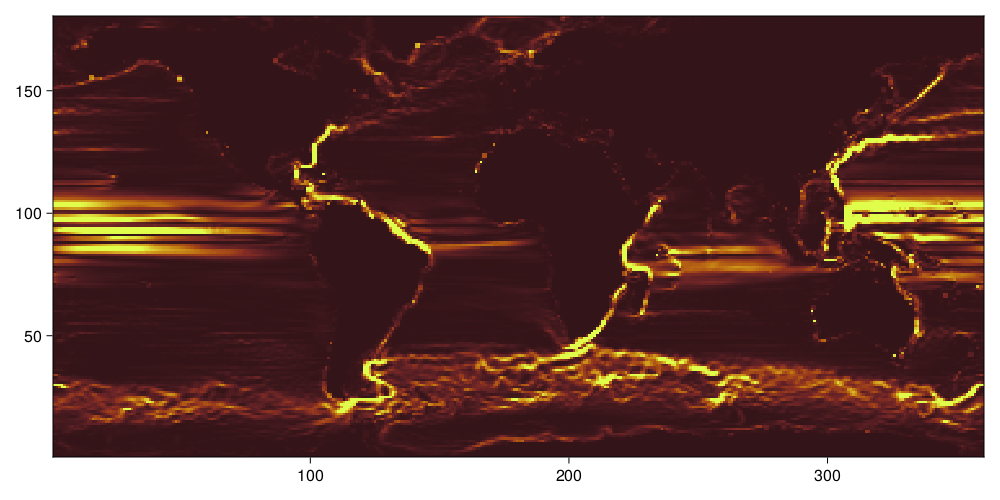

In [18]:
k = interior(K)

# The data associated with a field is always three dimensional!
@show typeof(k);

fig = Figure(resolution = (1000, 500))
ax = Axis(fig[1, 1])
heatmap!(ax, k[:, :, 1], colorrange = (0, 0.05), colormap = :solar)

current_figure()

### Computing derivatives

In the same way we can compute derivatives. <br>
For example, let's calculate and plot the latitudinal derivative of the zonal velocity
$$S = \frac{\partial U}{\partial x}$$

Note that julia supports Unicode. <br>
The differentiation operator in Oceananigans is defined with the $\partial$ symbol. <br>
To write it out in julia, type `\partial` and then press the TAB key

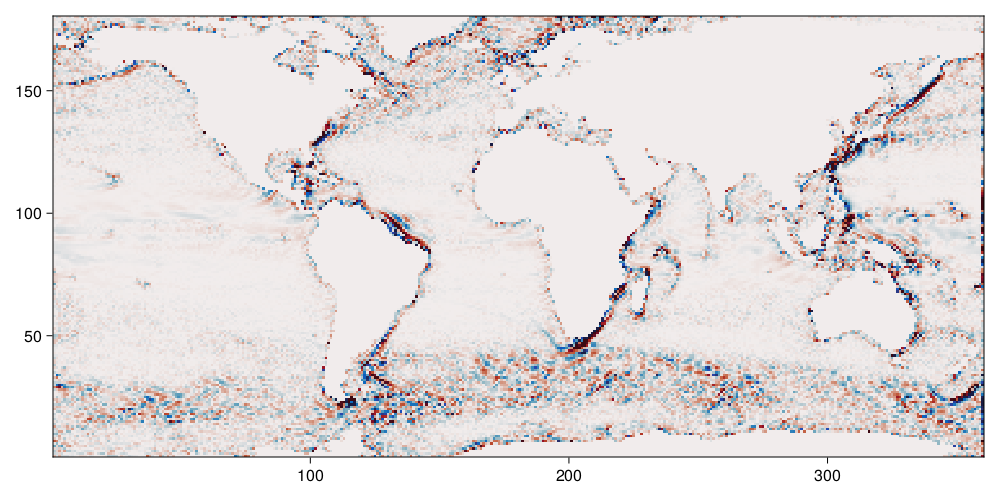

In [20]:
S = Field(∂x(U))
compute!(S)

s = interior(S)

fig = Figure(resolution = (1000, 500))
ax  = Axis(fig[1, 1])
heatmap!(ax, s[:, :, 1], colorrange = (-2e-6, 2e-6), colormap = :balance)

current_figure()

## Exercise: interact with the velocity field

define and plot the z-component of vorticity ($\zeta$) defined as

$$\zeta = \frac{\partial V}{\partial x} - \frac{\partial U}{\partial y}$$

#### Remember!
- the derivative operator in Oceananigans is constructed with \partial+TAB (followed by the direction: x or y)
- heatmap plots 2D AbstractArrays (SubArrays are AbstractArrays)
- the data of a field is retrieved by the `interior` function
- Fields are _always_ three dimensional

#### Tips
- You can use the `typeof` and `size` function to confirm that the variable you want to plot is a 2D array (or matrix)
- Follow the example above for plotting and use `colorrange = (-2e-6, 2e-6)` and `colormap = :blues`
- don't forget to display the figure with `current_figure()` at the end of the cell!

In [ ]:
## Write the new grid here
## look at the examples above:

# - define the operation you want to calculate (ex: U + 0.5 * V)
# - wrap it around a Field constructor (field = Field(expression))
# - compute the field with compute!(field)
# - extract the data with data = interior(field)
# - display the data with heatmap!
